#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16525, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 16525 (delta 0), reused 2 (delta 0), pack-reused 16522
Receiving objects: 100% (16525/16525), 15.05 MiB | 14.88 MiB/s, done.
Resolving deltas: 100% (11353/11353), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.2.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [ ]:
%cd /content/yolov5

/content/yolov5


In [ ]:
!unzip /content/dataset.zip


Archive:  /content/dataset.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
 extracting: test/images/img-101_jpg.rf.ab53db8af9aa3684272a0d8ef55089e4.jpg  
 extracting: test/images/img-11_jpg.rf.d60ffe0a8c8482775908b6706961a5e7.jpg  
 extracting: test/images/img-12_jpg.rf.9a7289553631e6f912d1c433c1dcd68b.jpg  
 extracting: test/images/img-134_jpg.rf.3ea1255e42d28da2bcc63a1b1ba7b511.jpg  
 extracting: test/images/img-137_jpg.rf.00671bc57daadf451e232887a439526c.jpg  
 extracting: test/images/img-139_jpg.rf.35b18eafbabc0e5bf0825f5fd6db9037.jpg  
 extracting: test/images/img-152_jpg.rf.58b64ad33f7e8048fdfaf337d6588440.jpg  
 extracting: test/images/img-155_jpg.rf.711710f0d55a4303a04699283a975f69.jpg  
 extracting: test/images/img-159_jpg.rf.efd6bd9f8b2fb0b59b38900734b5c42e.jpg  
 extracting: test/images/img-162_jpg.rf.3386d54aa8974183008542245fc9fd27.jpg  

In [ ]:
!ls

benchmarks.py	 data	    hubconf.py		README.md	     segment	train.py
CITATION.cff	 data.yaml  LICENSE		README.roboflow.txt  setup.cfg	tutorial.ipynb
classify	 detect.py  models		README.zh-CN.md      test	utils
CONTRIBUTING.md  export.py  README.dataset.txt	requirements.txt     train	val.py


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat /content/data.yaml

train: /content/yolov5/train/images
val: /content/yolov5/test/images

nc: 1
names: ['pothole']

# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open("/content/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 300 --data /content/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2024-04-09 06:32:14.142176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 06:32:14.142243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 06:32:14.143675: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 06:32:15.440139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, no

# Evaluate Custom YOLOv5 Detector Performance

You can view the training graphs associated with a training job in the `/content/yolov5/runs/train/yolov5s_results/results.png` folder.

Training losses and performance metrics are also saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

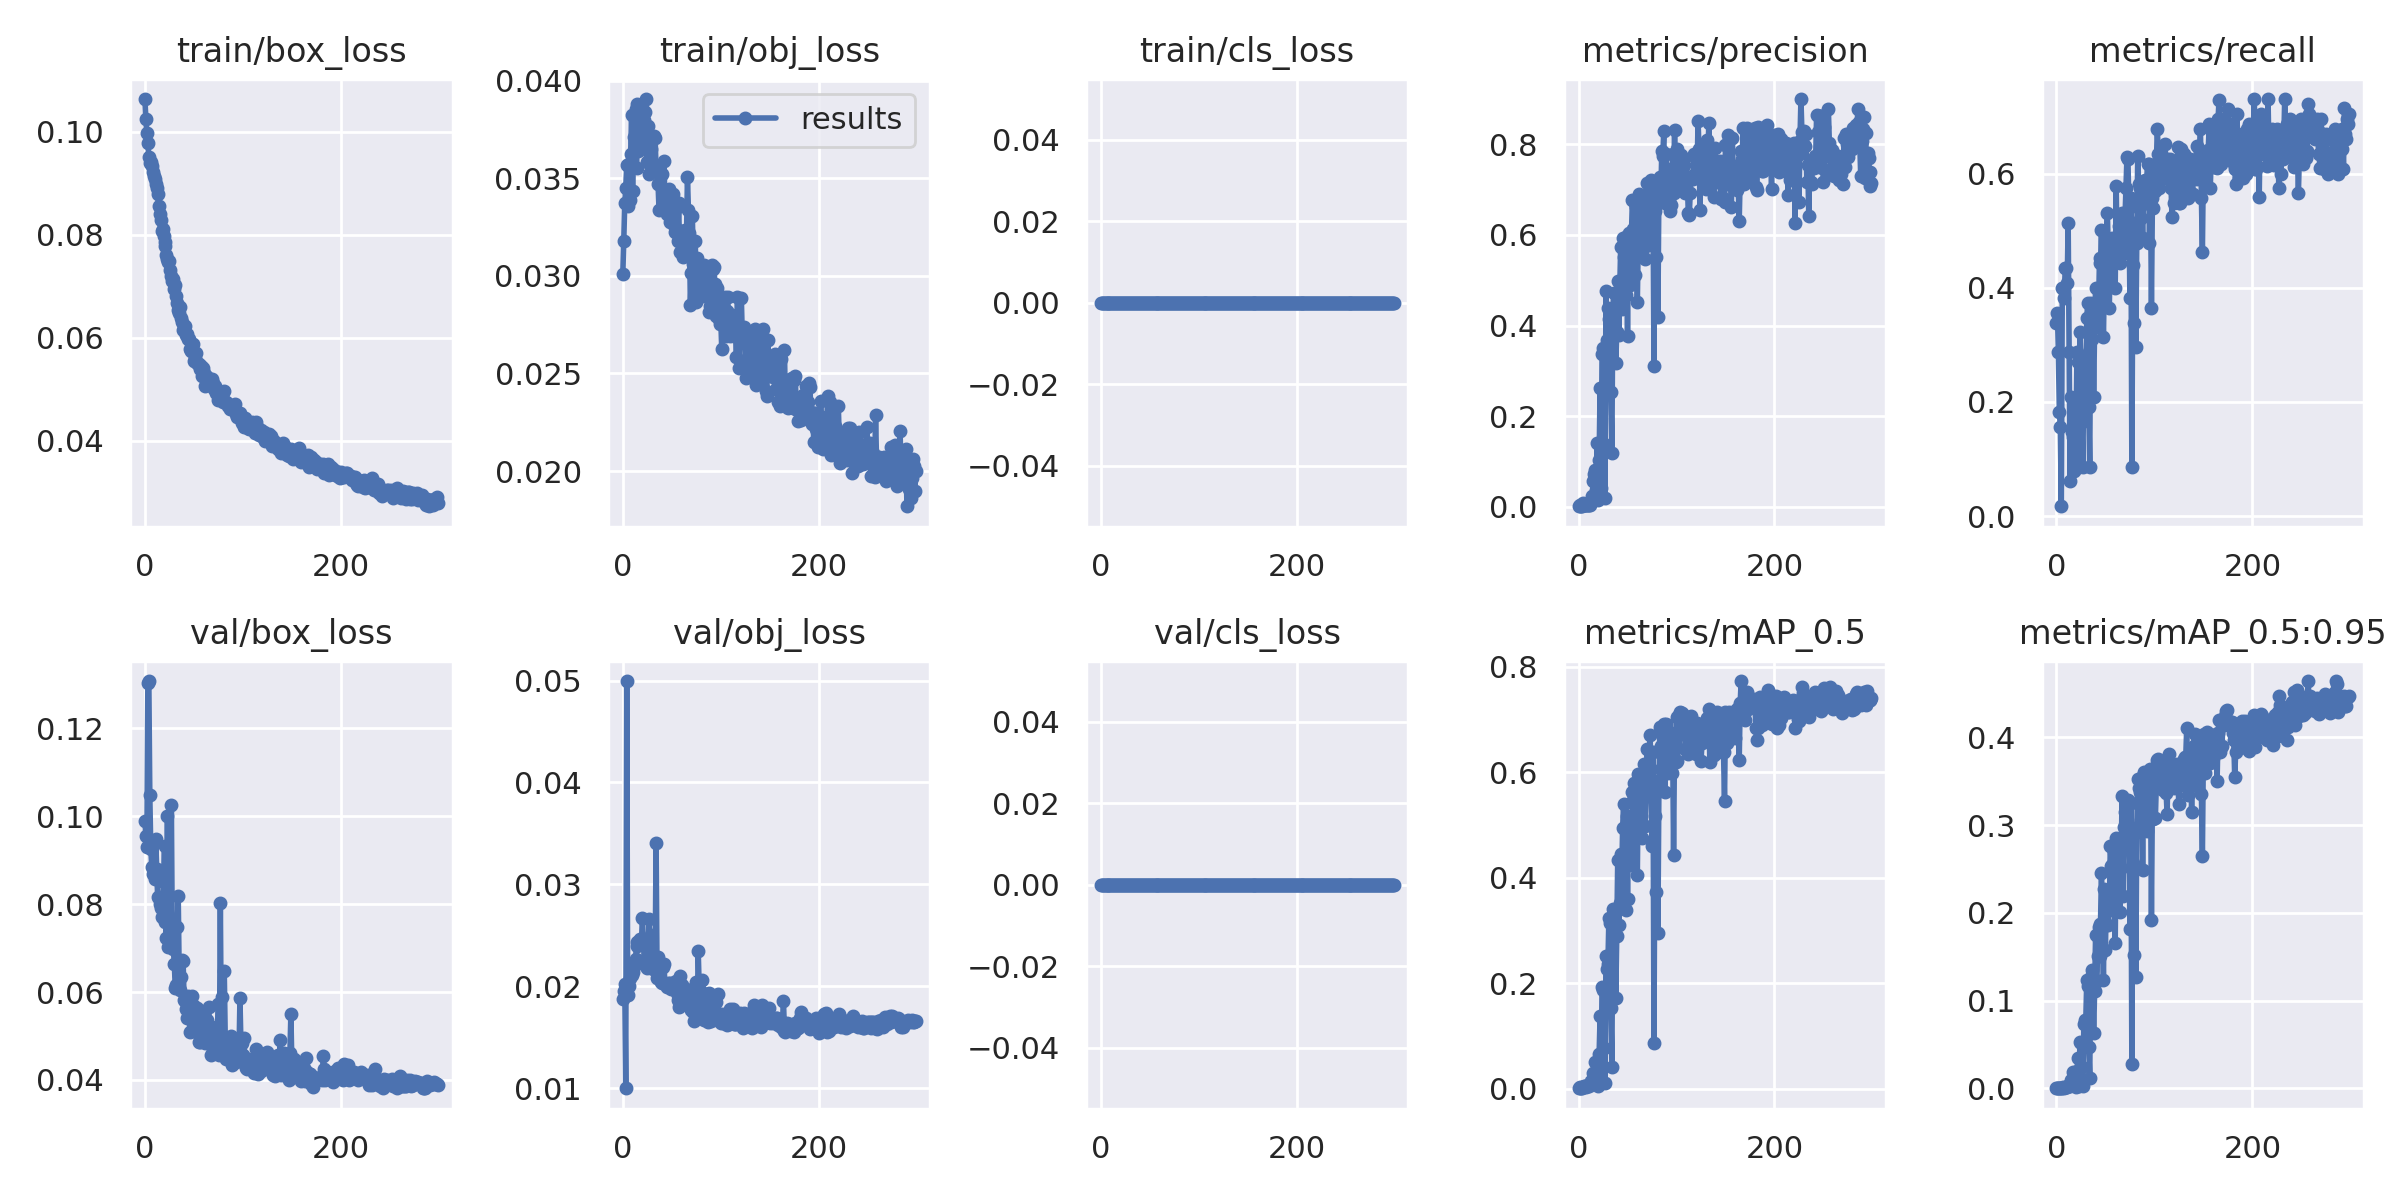

In [ ]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results2/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

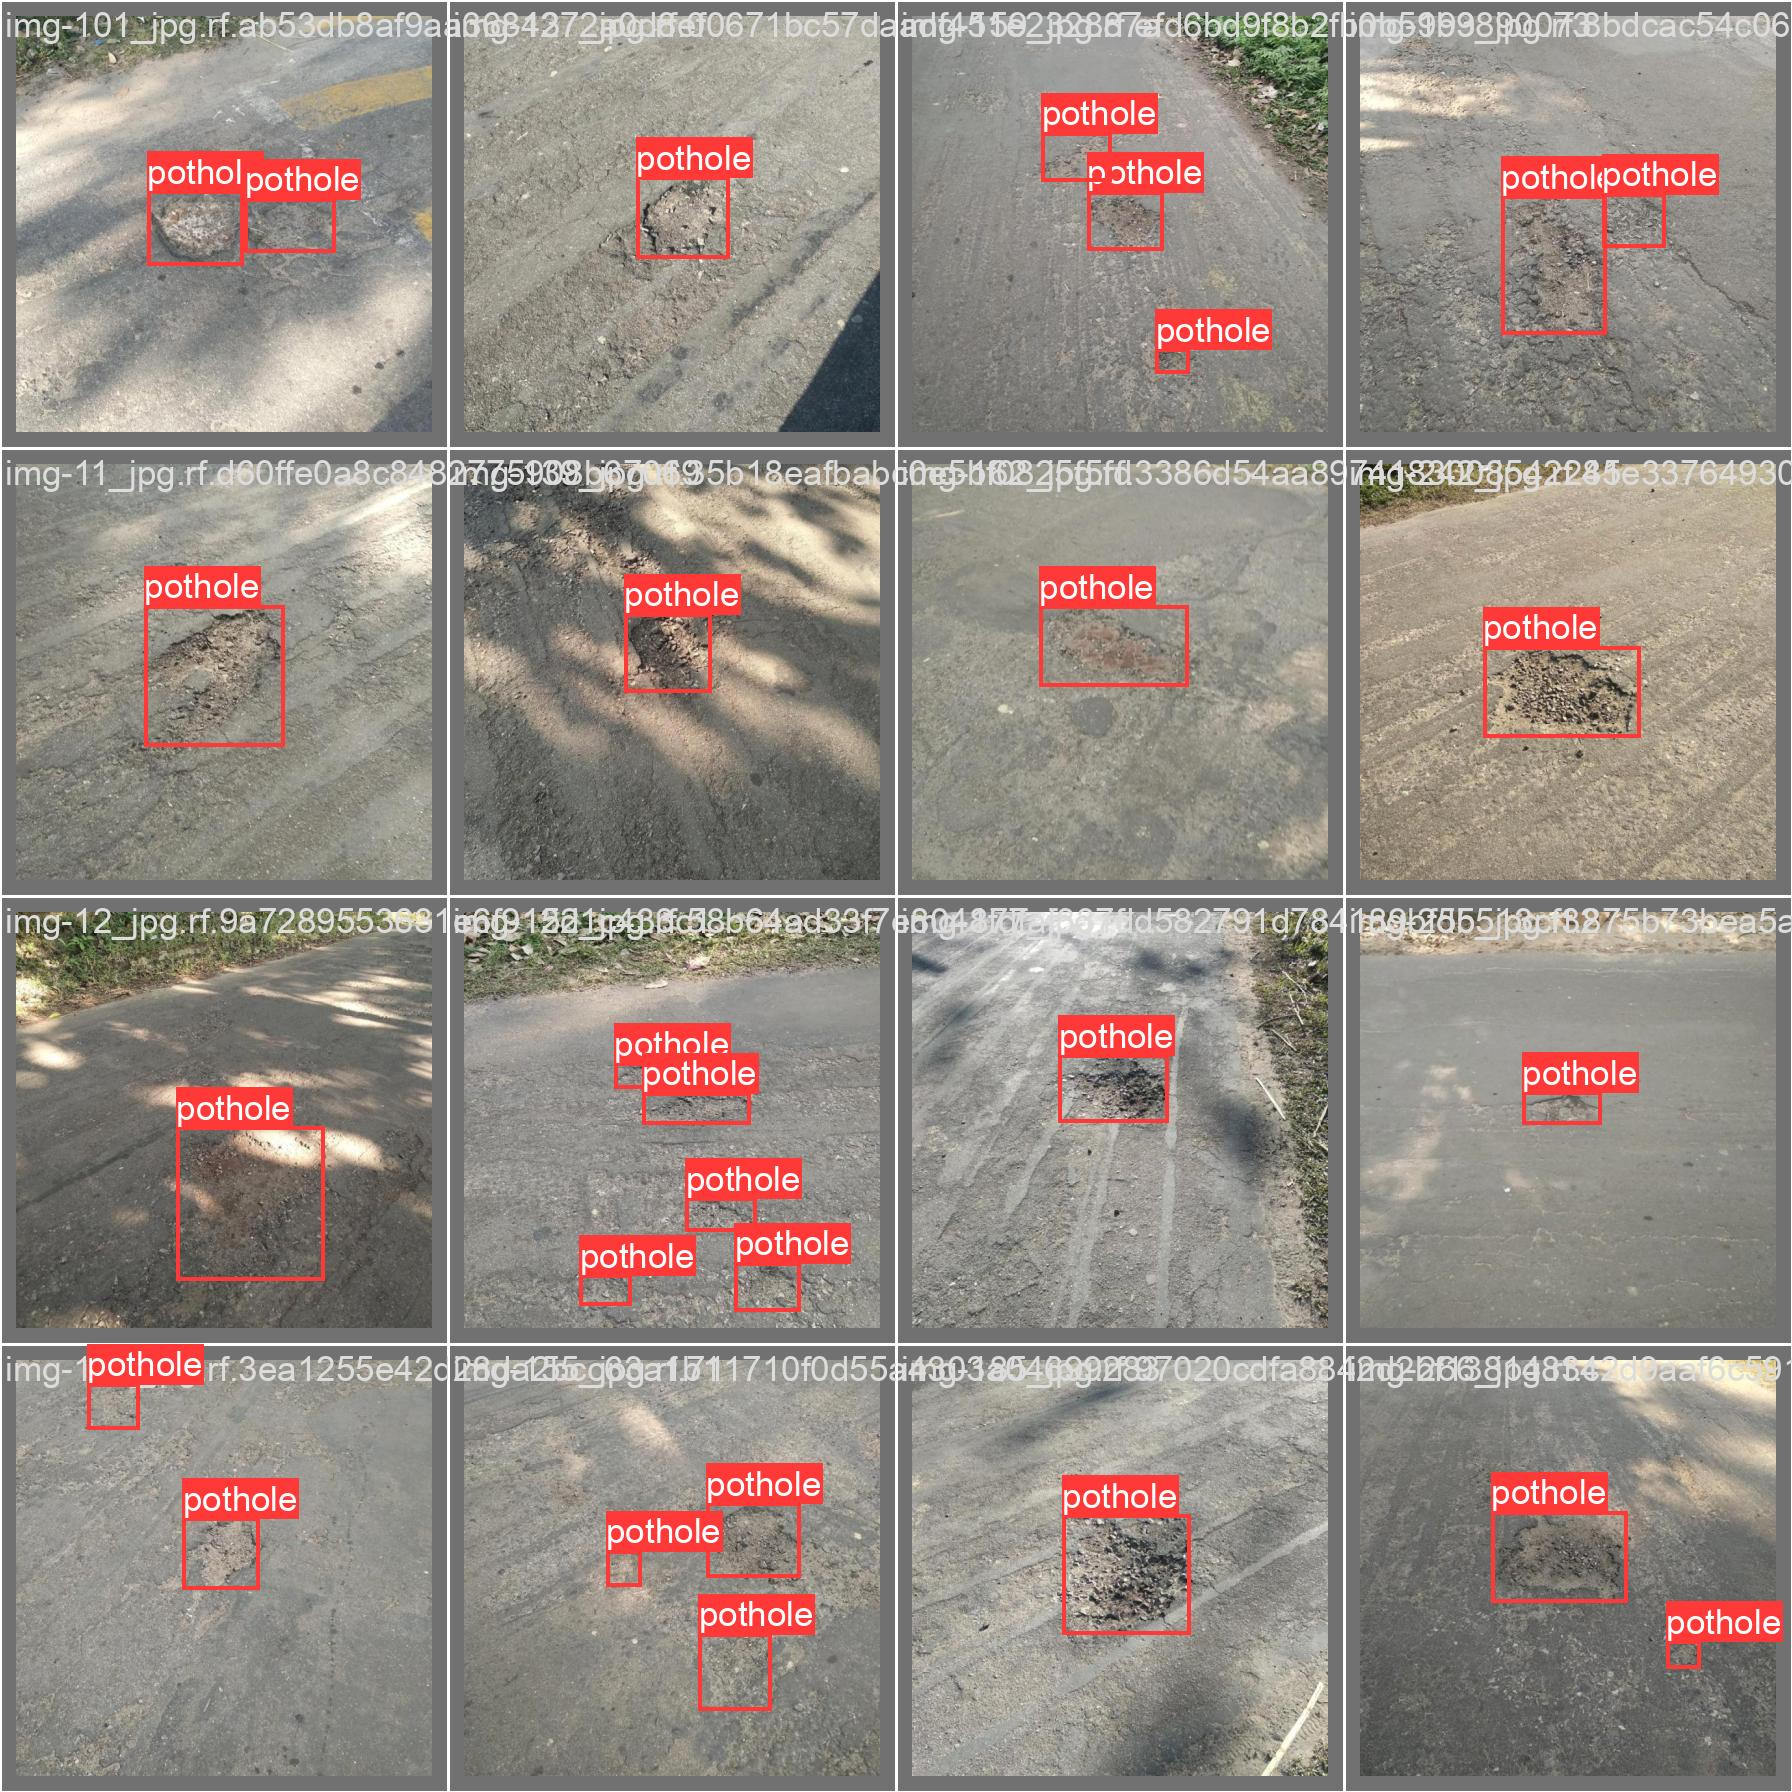

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


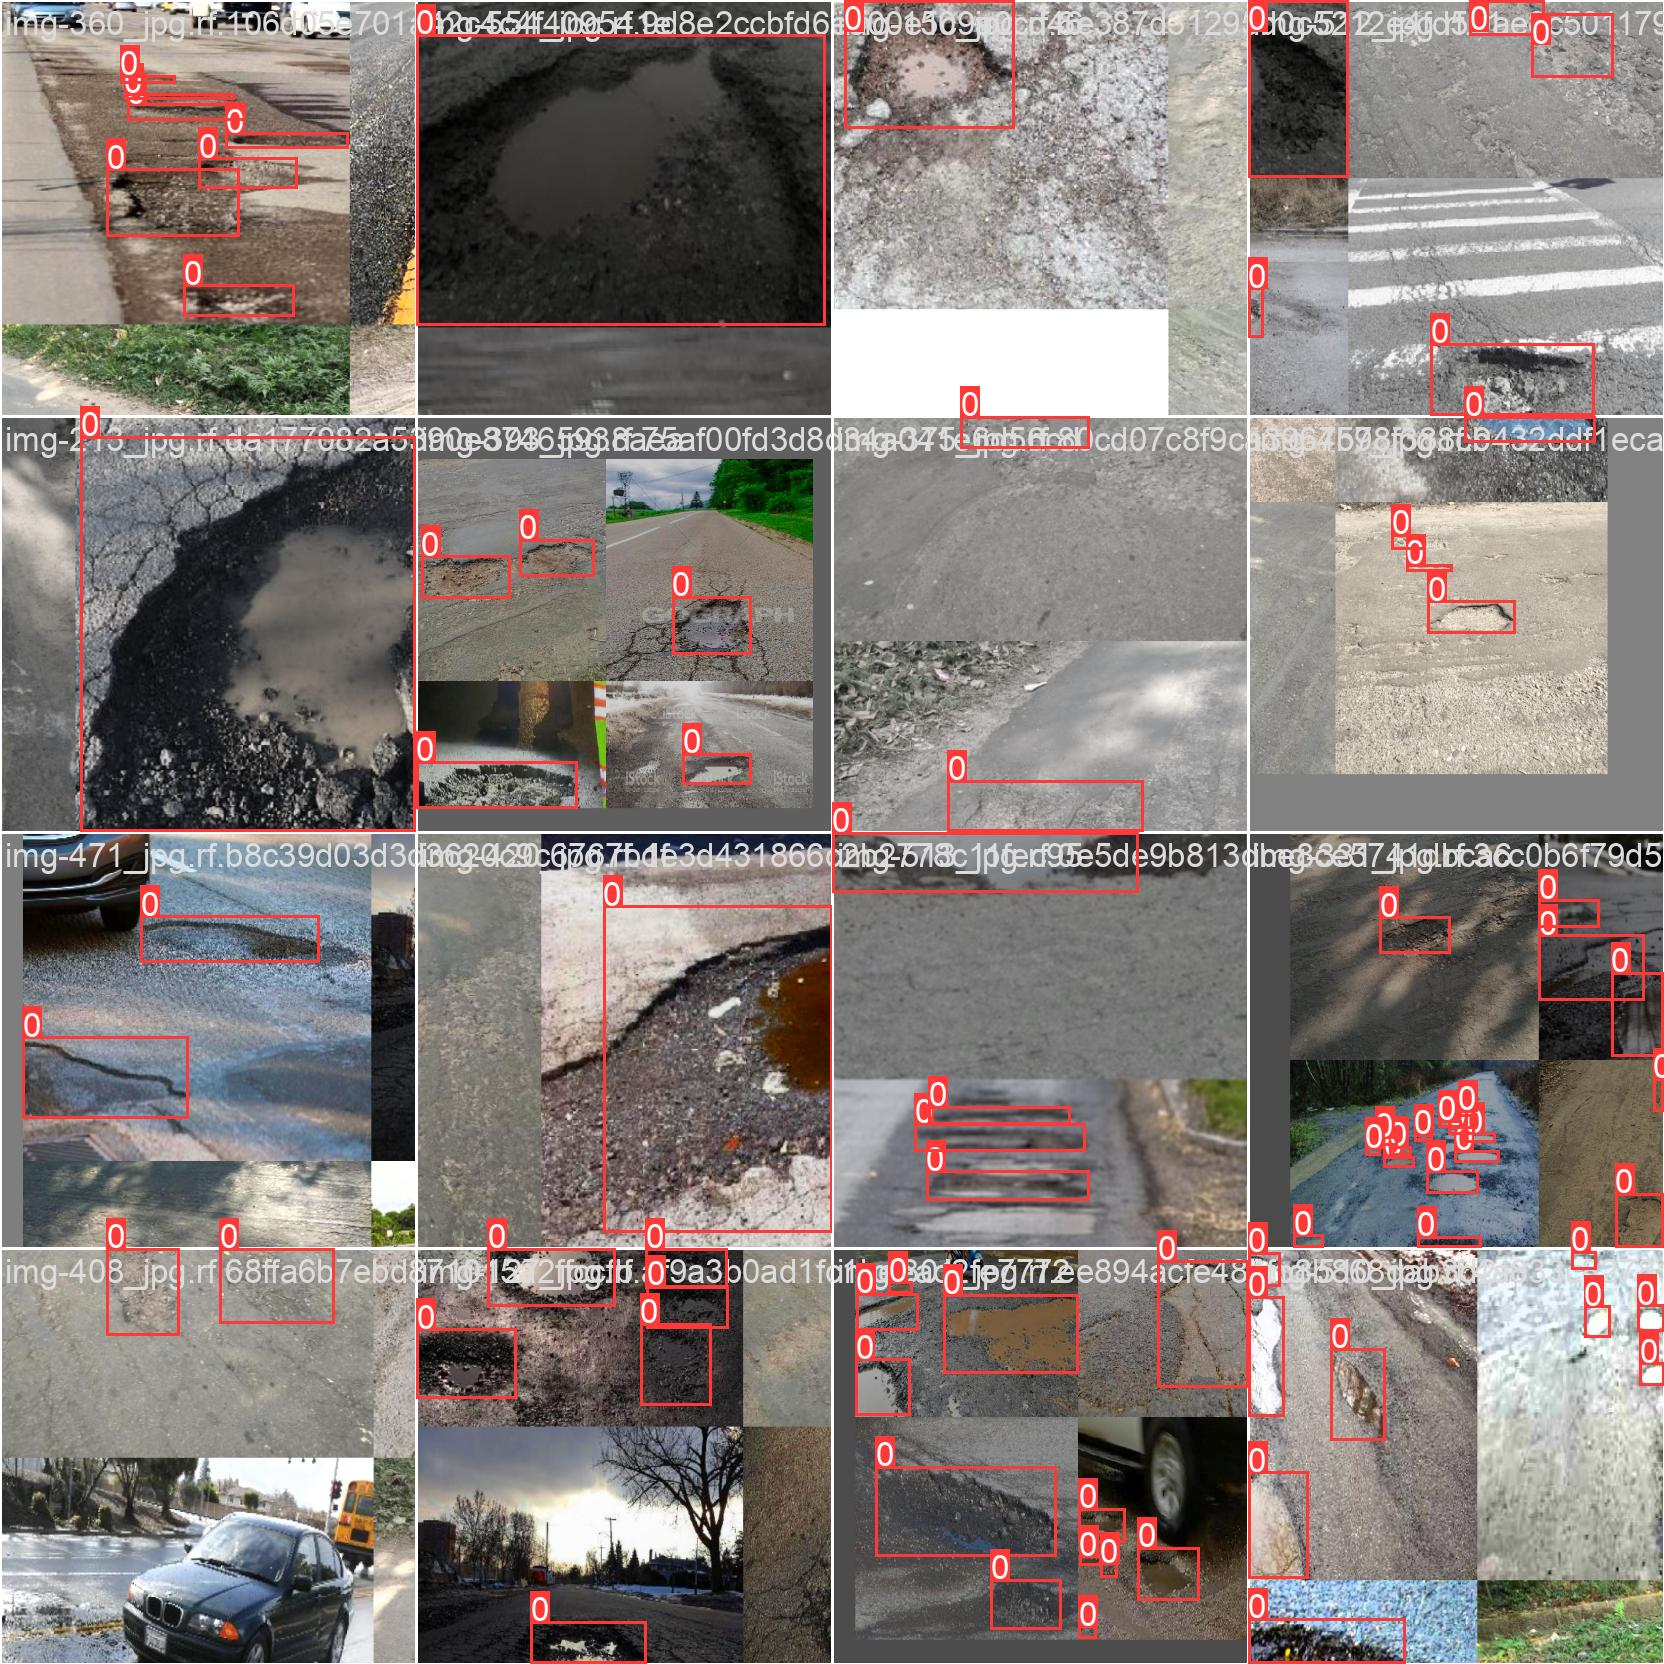

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

# Run Inference With Trained Weights

Next, we can run inference with a pretrained checkpoint on all images in the `test/images` folder to understand how our model performs on our test set.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In the snippet below, replace `Cash-Counter-10` with the name of the folder in which your dataset is stored.

In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source https://youtu.be/3SxG9dZdF74?si=SymPUKvnxGUKUjmy

Streaming output truncated to the last 5000 lines.
0: 256x416 1 pothole, 7.4ms
0: 256x416 1 pothole, 8.2ms
0: 256x416 1 pothole, 6.9ms
0: 256x416 1 pothole, 6.4ms
0: 256x416 1 pothole, 6.2ms
0: 256x416 1 pothole, 6.5ms
0: 256x416 1 pothole, 6.5ms
0: 256x416 1 pothole, 6.3ms
0: 256x416 1 pothole, 6.7ms
0: 256x416 1 pothole, 6.3ms
0: 256x416 1 pothole, 6.3ms
0: 256x416 1 pothole, 6.5ms
0: 256x416 1 pothole, 6.3ms
0: 256x416 1 pothole, 8.1ms
0: 256x416 1 pothole, 10.2ms
0: 256x416 1 pothole, 7.5ms
0: 256x416 1 pothole, 6.7ms
0: 256x416 1 pothole, 11.4ms
0: 256x416 1 pothole, 7.0ms
0: 256x416 1 pothole, 8.5ms
0: 256x416 1 pothole, 6.8ms
0: 256x416 1 pothole, 7.1ms
0: 256x416 1 pothole, 7.3ms
0: 256x416 1 pothole, 7.1ms
0: 256x416 1 pothole, 7.3ms
0: 256x416 1 pothole, 7.1ms
0: 256x416 1 pothole, 6.7ms
0: 256x416 1 pothole, 7.2ms
0: 256x416 1 pothole, 13.5ms
0: 256x416 (no detections), 7.1ms
0: 256x416 (no detections), 7.7ms
0: 256x416 (no detections), 9.5ms
0: 256x416 (no detections), 8.8m

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/yolov5/runs/detect/exp7/my.mp4